# Feature selection in high-dimensional genetic data

# Notebook 3: Network-constrained Lasso

## Introduction

In this notebook, we implement the network-constrained Lasso, which adds a regularization terms that ensures that the regression weights vary smoothly on a provided network. When the truly non-zero features are indeed connected on this network, the constraint helps identifying them.

In [1]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 14}) # font size for text on plots

## Conversion of the ncLasso problem into a lasso problem

The ncLasso problem is formulated as follows:

$\widehat{\beta} = \arg\min_{\beta \in \mathbb{R}^p} ||y - X \beta||_2^2 + \lambda_1 ||\beta||_1 + \lambda_2 \beta^\top L \beta$

where $L$ is the normalized graph Laplacian of a given network and the $\beta^\top L \beta$ regularizers imposes that the entries of $\beta$ vary smoothly on the network.

Given a matrix $S \in \mathbb{R}^{p \times m}$ such that $L = SS^\top$, the ncLasso problem can be reformulated as a lasso problem of regularization parameter $\gamma = \frac{\lambda_1}{\sqrt{1+\lambda_2}}$ by creating a "fake" data matrix $X_{new} \in \mathbb{R}^{(n+m) \times p}$ and a corresponding response vector $y_{new} \in \mathbb{R}^{(n+m)}$ where

$X_{new} = (1 + \lambda_2)^{-1/2} \begin{pmatrix} X \\ \sqrt{\lambda_2}S^\top \end{pmatrix}$

and 

$y_{new} = \begin{pmatrix} y \\ 0 \end{pmatrix}$

Indeed, if we call $\beta^*$ the solution of

$\beta^* = \arg\min_{\beta \in \mathbb{R}^p} ||y_{new} - X_{new} \beta||_2^2 + \gamma ||\beta||_1,$

then $\widehat{\beta} = \frac{1}{\sqrt{1+\lambda_2}}\beta^*.$

The proof is available in Lemma 1 of the [Li and Li (2008) paper](https://academic.oup.com/bioinformatics/article/24/9/1175/206444).

### Defining the ncLasso class

Assuming the matrix S is available, let us create a class for the ncLasso, which is not implemented in `sklearn`. 

In [3]:
from sklearn import base, linear_model

In [4]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, S_transposed=None, lambda1=1.0, lambda2=1.0):
        self.S_transposed = S_transposed # sparse matrix S_transposed
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y, max_iter=1000): 
        denominator = np.sqrt(1. + self.lambda2)
        
        # transformed regularization parameter
        gamma = self.lambda1 / denominator
        # initialize lasso
        self.lasso = linear_model.Lasso(fit_intercept=True, 
                                        alpha=gamma, max_iter=max_iter)
        # transformed response vector
        y_new = np.hstack((y, np.zeros((self.S_transposed.shape[0], ))))
        
        # transformed design matrix
        X_new = np.vstack((X, np.sqrt(self.lambda2) * self.S_transposed)) / denominator
        
        # run the Lasso
        self.lasso.fit(X_new, y_new)
        
        # transform beta (regression weights) back
        self.coef_ = self.lasso.coef_[:X.shape[1]] / denominator
        return self
        
        
    def predict(self, X, y = None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y = None):
        return self.lasso.score(X, y)                                        

## Resources requirements

There are two obvious choices for $S$ :
1) The matrix $S = U \Delta^{1/2}$, of dimension $p \times p$, obtained from the spectral decomposition of $L$ as $L = U \Delta U^\top$.
2) The incidence matrix, a $p \times m$ matrix, where $m$ is the number of edges, and $S_{ik} \neq 0$ iff nodes $i$ is one of the two nodes connected by edge $k$ (see for example [this blog post by Matthew N. Bernstein](https://mbernste.github.io/posts/laplacian_matrix/)).

The first choice requires computing the spectral decomposition of $L$ (time consuming) and the resulting matrix $S$ is dense (memory consuming).
The second choice requires computing the incidence matrix, which is sparse (hence memory requirements aren't intensive), and quite efficient to compute. 
However, in the first case, the matrix $X_{new}$ is of dimension $(n+p) \times p$, which is much smaller than the $X_{new}$ from the second choice, where the dimension is $(n+m) \times p$, and the Lasso will hence be faster to solve.

Because both these options require a lot of resources (time, memory, both), it is not practical to run them on our _Arabidopsis thaliana_ dataset. For example, on my laptop, computing the spectral decomposition of the normalized Laplacian takes 22 minutes and the resulting matrix $S$ takes up more than 2GB of memory. One run of the Lasso on the transformed data (i.e. no cross-validation, for one value of $\lambda_1$ and one value of $\lambda_2$ takes 5-10 minutes. Computing the normalized incidence matrix doesn't take much time, but it takes several 

We will therefore work here with a smaller, simulated data set to illustrate the concepts.

## Data simulation

In [5]:
# Data size
num_features = 1000
num_samples = 150

### Graph over the features

In [6]:
# Size of a network module (all features in a module are connected)
module_size = 10

# adjacency matrix
W_simu = np.zeros((num_features, num_features))
for i in range(int(num_features/module_size)):
    W_simu[i*module_size:(i+1)*module_size, i*module_size:(i+1)*module_size] = np.ones((module_size, module_size))
    if not i == (num_features/module_size - 1):
        W_simu[(i+1)*module_size-1, (i+1)*module_size] = 1
        W_simu[(i+1)*module_size, (i+1)*module_size-1] = 1
        
# remove the diagonal
W_simu = W_simu - np.eye(num_features)

### Simulated features

In [7]:
# Features
X_simu = np.random.binomial(1, 0.1, size=(num_samples, num_features))

### Simulated outcome 

In [8]:
# use a small number of causal features
num_causal_features = 10

w_causl = np.random.normal(loc=0.2, scale=0.05, size=(num_causal_features))

w = np.zeros((num_features, ))
w[:num_causal_features] = w_causl

y_simu = np.dot(X_simu, w) + np.random.normal(loc=0., scale=0.1, size=(num_samples, ))

## Lasso on the simulated data

Let us now cross-validate a lasso on `(X_simu, y_simu)`. We'll only look at whether the features with non-zero coefficients match the causal features, so we don't need to split the data in train and test sets.

In [9]:
lasso = linear_model.Lasso(fit_intercept=True, max_iter=6000)

In [11]:
from sklearn import model_selection

In [12]:
alphas = np.logspace(-5., -1., num=20)
model_l1_simu = model_selection.GridSearchCV(lasso, param_grid = {'alpha': alphas}, 
                                        scoring = 'explained_variance')
model_l1_simu.fit(X_simu, y_simu)

GridSearchCV(estimator=Lasso(max_iter=6000),
             param_grid={'alpha': array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01])},
             scoring='explained_variance')

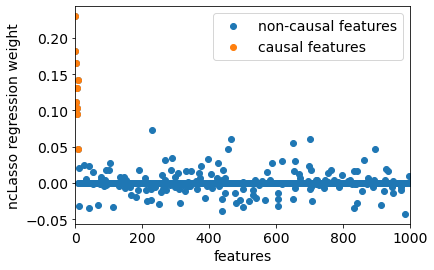

In [13]:
plt.scatter(range(num_features), model_l1_simu.best_estimator_.coef_, label='non-causal features')

# Plot the causal SNPs in red
causal_indices = np.arange(num_causal_features)
plt.scatter(causal_indices, model_l1_simu.best_estimator_.coef_[causal_indices], label='causal features')

plt.xlabel("features")
plt.ylabel("ncLasso regression weight")
plt.xlim([0, num_features])
plt.legend()

In [14]:
print("The lasso selected %d features." % np.nonzero(model_l1_simu.best_estimator_.coef_)[0].shape)

The lasso selected 185 features.


The lasso correctly identifies the causal features, but also assigns non-zero weights to a large number of non-causal features.

## Spectral decomposition of the normalized Laplacian

We will now compute the matrix S using the normalized Laplacian of the graph.

__Computation of the normalized Laplacian:__
$L_{uv} = \begin{cases}1  & \text{ if } u=v \\
-\frac{W_{uv}}{\sqrt{d_u d_v}} & \text { otherwise} \end{cases}$

where $d_u$ is the degree of node $u$.

In [15]:
# compute the node degrees
degrees = np.sum(W_simu, axis=0)

# compute the squared root of the node degrees
degrees_sqrt = np.sqrt(degrees)

In [16]:
# Create the normalized adjacency matrix 
W_normalized = W_simu / np.dot(degrees_sqrt.reshape((num_features, 1)), degrees_sqrt.reshape((1, num_features)))

In [17]:
normalized_laplacian = np.diag(np.ones(num_features,)) - W_normalized

In [18]:
# spectral decomposition of the laplacian
evals, evecs = np.linalg.eigh(normalized_laplacian)

In [19]:
# correcting for numerical errors: 
# eigenvalues of 0 might be computed as small negative numbers
evals = np.maximum(0, evals)

In [20]:
# Computing S = U D^{1/2}
laplacian_root = np.dot(evecs, np.diag(np.sqrt(evals)))

## Running ncLasso with fixed values of $\lambda_1$, $\lambda_2$

In [21]:
model_nclasso_simu = ncLasso(laplacian_root, 1e-4, 1)

In [22]:
model_nclasso_simu.fit(X_simu, y_simu, max_iter=2000)

ncLasso(S_transposed=array([[ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04],
       [ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04],
       [ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04],
       ...,
       [ 3.16769461e-10,  1.32277309e-04, -2.64437744e-04, ...,
         1.01659794e-03,  6.78381462e-04,  3.39385702e-04],
       [ 3.16769461e-10,  1.32277309e-04, -2.64437744e-04, ...,
         1.01659794e-03,  6.78381462e-04,  3.39385702e-04],
       [ 3.16769461e-10,  1.32277309e-04, -2.64437744e-04, ...,
         1.01659794e-03,  6.78381462e-04,  3.39385702e-04]]),
        lambda1=0.0001, lambda2=1)

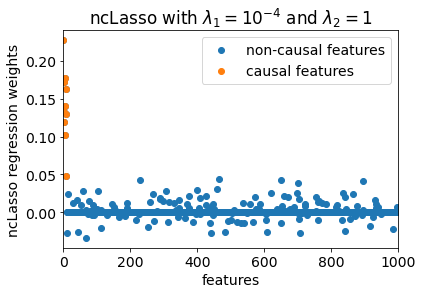

In [23]:
plt.scatter(range(num_features), model_nclasso_simu.coef_, label='non-causal features')

# Plot the causal SNPs in red
causal_indices = np.arange(num_causal_features)
plt.scatter(causal_indices, model_nclasso_simu.coef_[causal_indices], label='causal features')

plt.xlabel("features")
plt.ylabel("ncLasso regression weights")
plt.title(r"ncLasso with $\lambda_1 = 10^{-4}$ and $\lambda_2 = 1$")
plt.xlim([0, num_features])
plt.legend()

In [24]:
print("The ncLasso with regularization parameters (1e-3, 10) selected %d features." % np.nonzero(model_nclasso_simu.coef_)[0].shape)

The ncLasso with regularization parameters (1e-3, 10) selected 165 features.


## Selecting hyperparmeters for ncLasso by cross-validation

In [25]:
nc_lasso = ncLasso(laplacian_root)

In [26]:
%%time
lambda1_list = np.logspace(-5., -3., num=5)
lambda2_list = np.logspace(1., 2, num=5)

model_nclasso_simu = model_selection.GridSearchCV(nc_lasso, param_grid = {'lambda1': lambda1_list, 'lambda2': lambda2_list}, 
                                        scoring = 'explained_variance')
model_nclasso_simu.fit(X_simu, y_simu)

CPU times: user 33.5 s, sys: 1min 27s, total: 2min
Wall time: 16.4 s


GridSearchCV(estimator=ncLasso(S_transposed=array([[ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04],
       [ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04],
       [ 3.16769461e-10, -1.32277309e-04, -2.64437744e-04, ...,
        -1.01659794e-03,  6.78381462e-04, -3.39385702e-04]...
       [ 3.16769461e-10,  1.32277309e-04, -2.64437744e-04, ...,
         1.01659794e-03,  6.78381462e-04,  3.39385702e-04],
       [ 3.16769461e-10,  1.32277309e-04, -2.64437744e-04, ...,
         1.01659794e-03,  6.78381462e-04,  3.39385702e-04]])),
             param_grid={'lambda1': array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03]),
                         'lambda2': array([ 10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
       100.        ])},
             scoring='explained_variance')

In [27]:
model_nclasso_simu.best_params_

{'lambda1': 0.001, 'lambda2': 10.0}

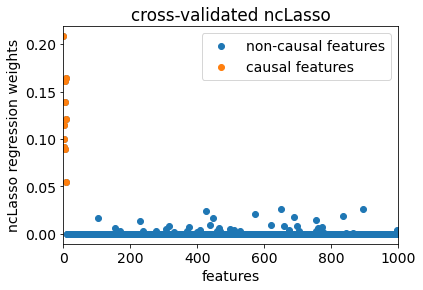

In [28]:
plt.scatter(range(num_features), model_nclasso_simu.best_estimator_.coef_, label='non-causal features')

# Plot the causal SNPs in red
causal_indices = np.arange(num_causal_features)
plt.scatter(causal_indices, model_nclasso_simu.best_estimator_.coef_[causal_indices], label='causal features')

plt.xlabel("features")
plt.ylabel("ncLasso regression weights")
plt.title("cross-validated ncLasso")
plt.xlim([0, num_features])
plt.legend()

In [29]:
print("The cross-validated ncLasso selected %d features." % np.nonzero(model_nclasso_simu.best_estimator_.coef_)[0].shape)

The cross-validated ncLasso selected 54 features.


The ncLasso did not manage to select only the relevant features, but the number of non-relevant features is much lower than for the Lasso. Also, the coefficients associated with those non-causal features seem lower than for the Lasso.

## Running the network-constrained lasso on the _A. thaliana_ data 

Here is code you can uncomment and use to run ncLasso on the _A. thaliana_ data. It is too time- and memory-consuming to run comfortably during our practical session, but you can play with it later on.

### Loading the data again

In [30]:
# import pandas as pd

In [31]:
# # Loading the SNP names
# with open('data/athaliana_small.snps.txt') as f:
#     snp_names = f.readline().split()
#     f.close()
# print(len(snp_names))

In [32]:
# # Loading the design matrix -- this can take time!
# X = np.loadtxt('data/athaliana_small.X.txt',  # file names
#                dtype = 'int') # values are integers
# p = X.shape[1]

In [33]:
# # Loading the samples
# samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
#                          dtype=int)) # values are integers

In [34]:
# # Loading the phenotypes
# df_2W = pd.read_csv('data/athaliana.2W.pheno', # file name
#                  header=None, # columns have no header
#                  delim_whitespace=True, # columns are separated by white space
#                  index_col=0) # read the first column as index

# # Create vector of sample IDs
# samples_with_phenotype_2W = list(df_2W.index)
# print(len(samples_with_phenotype_2W), "samples have a 2W phenotype")

# # Create vector of phenotypes
# y_2W = df_2W[1].to_numpy()

# # Restricting the design matrix to those samples who have a 2W phenotype
# X_2W = X[np.array([samples.index(sample_id) \
#                    for sample_id in samples_with_phenotype_2W]), :]

# # Delete X to free space
# del X

In [35]:
# # Loading the list of candidate genes
# with open('data/athaliana.candidates.txt') as f:
#     candidate_genes = f.readline().split()
#     f.close()

In [36]:
# # Loading the SNPs-to-gene mapping
# genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
# with open('data/athaliana.snps_by_gene.txt') as f:
#     for line in f:
#         ls = line.split()
#         gene_id = ls[0]
#         for snp_id in ls[1:]:
#             if not snp_id in genes_by_snp:
#                 genes_by_snp[snp_id] = []
#             genes_by_snp[snp_id].append(gene_id) 

In [37]:
# # Splitting the data into a train and test set
# from sklearn import model_selection

# X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
#     model_selection.train_test_split(X_2W, y_2W, test_size=0.2, 
#                                      random_state=17) # use the same random_state as in Notebook 1 to obtain the same split
# print(X_2W_tr.shape, X_2W_te.shape)

### Sparse version of the ncLasso class

In [38]:
# from scipy import sparse

In [39]:
# class ncLasso(base.BaseEstimator, base.RegressorMixin):
#     def __init__(self, S_transposed=None, lambda1=1.0, lambda2=1.0):
#         self.S_transposed = S_transposed # sparse matrix S_transposed
#         self.lambda1 = lambda1
#         self.lambda2 = lambda2
        
#     def fit(self, X, y, max_iter=1000): 
#         denominator = np.sqrt(1. + self.lambda2)
        
#         # transformed regularization parameter
#         gamma = self.lambda1 / denominator
#         # initialize lasso
#         self.lasso = linear_model.Lasso(fit_intercept=True, 
#                                         alpha=gamma, max_iter=max_iter)
#         # transformed response vector
#         y_new = np.hstack((y, np.zeros((self.S_transposed.shape[0], ))))
        
#         # transformed design matrix
#         X_new = sparse.vstack((X, np.sqrt(self.lambda2) * self.S_transposed)) / denominator
        
#         # run the Lasso
#         self.lasso.fit(X_new, y_new)
        
#         # transform beta (regression weights) back
#         self.coef_ = self.lasso.coef_[:X.shape[1]] / denominator
#         return self
        
        
#     def predict(self, X, y = None):
#         return self.lasso.predict(X)
    
    
#     def score(self, X, y = None):
#         return self.lasso.score(X, y)                                        

### Loading the network

In [40]:
# w_saved = np.loadtxt('data/athaliana_small.W.txt', dtype='int') 

The network is saved in coordinate (or triplet) format: each column is an edge, with the first line being the index of one of a node, the second line the index of another node it is connected to, and the last line the edge weight.

For example here `w_saved[:, 1000]` represents the 1000-th edge, which connects node index 27 to node index 2541 (with a weight of 1).

In [41]:
# w_saved[:, 1000]

In [42]:
# print("The network contains %d edges" % (w_saved.shape[1]))

Such a representation corresponds to the `coo` representation of sparse matrices in `scipy.sparse`

In [43]:
# # Create adjacency matrix in scipy.sparse.coo_matrix format
# W = sparse.coo_matrix((w_saved[2, :], (w_saved[0, :], w_saved[1, :])), shape = (p, p))

### Option 1: Spectral decomposition of the normalized Laplacian
On my computer, this takes 22 minutes; the matrix $U$ is 2,1 GB.

#### Computation of the matrix S

__Computation of the normalized Laplacian:__
$L_{uv} = \begin{cases}1  & \text{ if } u=v \\
-\frac{W_{uv}}{\sqrt{d_u d_v}} & \text { otherwise} \end{cases}$

where $d_u$ is the degree of node $u$.

In [44]:
# # compute the node degrees
# degrees = np.sum(W, axis=0).A1.flatten()

# # compute the squared root of the node degrees
# degrees_sqrt = np.sqrt(degrees)

# # normalize the edge weights
# normalized_edge_weights = w_saved[2, :]/(degrees_sqrt[w_saved[0, :]]*degrees_sqrt[w_saved[1, :]])

# # Create the normalized adjacency matrix in scipy.sparse.coo_matrix format
# W_normalized = sparse.coo_matrix((normalized_edge_weights, (w_saved[0, :], w_saved[1, :])),
#                                   shape = (p, p))

# # Compute the normalized Laplacian
# normalized_laplacian = sparse.diags(np.ones(p,)) - W_normalized

In [45]:
# %%time
# # spectral decomposition of the laplacian
# evals, evecs = np.linalg.eigh(normalized_laplacian.todense())

In [46]:
# # correcting for numerical errors: 
# # eigenvalues of 0 might be computed as small negative numbers
# evals = np.maximum(0, evals)

In [47]:
# laplacian_root = np.dot(evecs, np.diag(np.sqrt(evals)))

#### Running ncLasso

In [48]:
# model_nclasso = ncLasso(laplacian_root, 1e-4, 1e-4)

In [49]:
# %%time
# model_nclasso.fit(X_2W_tr, y_2W_tr, max_iter=2000)

In [50]:
# plt.figure(figsize = (6, 4))
# plt.scatter(range(p), # x = SNP position
#             model_nclasso.coef_)  # y = regression weights

# plt.xlabel("SNP")
# plt.ylabel("ncLasso regression weight")
# plt.xlim([0, p])

In [51]:
# print("%d SNPs selected," % \
#     np.nonzero(model_nclasso.coef_)[0].shape)

# candidate_genes_hit = set([])
# num_snps_in_candidate_genes = 0
# for snp_idx in np.nonzero(model_nclasso.coef_)[0]:
#     for gene_id in genes_by_snp[snp_names[snp_idx]]:
#         if gene_id in candidate_genes:
#             candidate_genes_hit.add(gene_id)
#             num_snps_in_candidate_genes += 1

# print("%d SNPs are in %d candidate genes" % (num_snps_in_candidate_genes, 
#                                                           len(candidate_genes_hit)))

In [52]:
# y_ncl1_pred = model_nclasso.predict(X_2W_te)
# print("%.3f" % metrics.explained_variance_score(y_2W_te, y_ncl1_pred))

### Option 2: Using the normalized incidence matrix

#### Computation of the matrix S

The incidence matrix $S$ is a $p \times m$ matrix, where $m$ is the number of edges, and $S_{ik} \neq 0$ iff nodes $i$ is one of the two nodes connected by edge $k$ (see for example [this blog post by Matthew N. Bernstein](https://mbernste.github.io/posts/laplacian_matrix/)). 

In the normalized version of the incidence matrix, if the $k$-th edge of the graph connects node $u$ to node $v$, with $u < v$, then $S_{uk} = \frac{1}{\sqrt{d_u}}$ and $S_{vk} = - \frac{1}{\sqrt{d_v}}.$

To construct $X_{new}$, we will need $S^\top$, so we directly compute the transposed incidence matrix.

In [53]:
# incidence_t = sparse.lil_matrix((w_saved.shape[1], p), dtype=float)
# for edge_idx, edge in enumerate(w_saved.T):
#     if edge[0] < edge[1]:
#         incidence_t[edge_idx, edge[0]] = 1/degrees_sqrt[edge[0]]
#         incidence_t[edge_idx, edge[1]] = -1/degrees_sqrt[edge[1]]

#### Running ncLasso 

Use the same code as with Option 1 to run ncLasso with the incidence matrix. __Warning__ On my computer, this takes several hours!